
# Tasca M8 T01
___


## Objectius

- Neteja i interpretació de les dades.
- Preprocessats i PCA.
- Trobar nombre de clústers òptim
- Creació de models. unsupervised (k-means i clustering jeràrquic).
- Interpretar els resultats.


## Exercici 1

Descarrega el dataset adjunt, de registres de publicacions a Facebook sobre Tailàndia, i classifica els diferents registres utilitzant l'algorisme de K-means.

### Preface

Doing a bit of research, we already found the origin of the dataset given to us. And since it belongs to a research paper, I believe that it would be more convenient to just quote some of it's highlights to get a sense of the whole original investigation, since the aim of this exercise is to cluster and the original one had a much broader approach. 


### Abstract from the original paper

>"Facebook pages of 10 Thai fashion and cosmetics retail sellers. Posts of a different nature (video, photos, statuses, and links).
Engagement metrics consist of comments, shares, and reactions".

>"This article describes a Comma Separated Values (CSV) dataset consisting of 7050 Facebook posts of various types (text, deferred and live videos, images). These posts were extracted from the Facebook pages of 10 Thai fashion and cosmetics retail sellers from March 2012, to June 2018. The dataset was collected via the Facebook API, and anonymized in compliance with the Facebook Platform Policy for Developers. For each Facebook post, the dataset records the resulting engagement metrics comprising shares, comments, and emoji reactions within which we distinguish traditional “likes” from recently introduced emoji reactions, that are “love”, “wow”, “haha”, “sad” and “angry”. This dataset could serve as a basis for research on customer engagement with the novel sales channel that is Facebook Live, through comparative studies with other forms of content (text, deferred videos, and images), as well as the statistical analysis of the seasonality of engagement and outlier posts."


### Imports

In [1]:
# Scientific and Data Manipulation Libraries :
import numpy as np
import pandas as pd
from numpy.random import seed
from datetime import datetime
from datetime import timedelta

# Data Visualization Libraries :
import matplotlib.pyplot as plt
import seaborn as sb 
sb.set_style('whitegrid')

# ML Libraries :
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer
from sklearn.metrics import silhouette_score




### Methods



In [2]:
def check_distribution(df):
#This method takes a dataframe then prints the number of columns and aks the user for the PlotGrid dimensions(NxN).
#Returns a Multiplot Histogram of each variable in a NxN Grid.
        
    # Inputs
    variables = df.columns
    print(f'Number of variables = {len(variables)}')
    n_rows = int(input('Desired Num of rows: '))
    n_cols = int(input('Desired Num of columns: '))
    
    #Plot
    sb.set(font_scale=1.2) 
    fig=plt.figure(figsize=((n_cols * 3),(n_rows * 3)))
    fig.patch.set_facecolor('slategrey')
    fig.suptitle('FEATURE DISTRIBUTION')
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=50, ax=ax, color='r')
        ax.set_title(var_name, size=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    #Aesthetics
    #fig.tight_layout()
    sb.set()
    plt.show()
    plt.close('all')
    
    
def outliers(feature):
# Prints an outlier resume about one feature
    # calculate interquartile range
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q75 - q25
    print(f'{feature.name.upper()}')
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in feature if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    # remove outliers
    non_outliers = [x for x in feature if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(non_outliers))
    proportion = len(outliers)/len(non_outliers)*100
    print(f'Outlier Percentage: {proportion:.2f} %\n')


# Exploratory Data Analysis (EDA)

## Dataset

Read the data

In [3]:
data = pd.read_csv('C:\\Users\\motxi\\Documents\\Data_Science_IT_Academy\\Sprints\\M08\\Publicacions Facebook Thailandia.csv')

Display data metrics and info

In [4]:
display(data.describe(include='all'))
display(data)
display(data.info())

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
count,7050,7050,7050,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,0.0,0.0,0.0,0.0
unique,6997,4,6913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,819700534875473_957599447752247,photo,3/20/2018 1:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,4288,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,230.117163,224.356028,40.022553,215.043121,12.728652,1.289362,0.696454,0.243688,0.113191,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,462.625309,889.636820,131.599965,449.472357,39.972930,8.719650,3.957183,1.597156,0.726812,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,59.500000,4.000000,0.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,219.000000,23.000000,4.000000,184.750000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN


,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,1050855161656896_1061863470556065,photo,9/24/2016 2:58,89,0,0,89,0,0,0,0,0,NaN,NaN,NaN,NaN
7046,1050855161656896_1061334757275603,photo,9/23/2016 11:19,16,0,0,14,1,0,1,0,0,NaN,NaN,NaN,NaN
7047,1050855161656896_1060126464063099,photo,9/21/2016 23:03,2,0,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN
7048,1050855161656896_1058663487542730,photo,9/20/2016 0:43,351,12,22,349,2,0,0,0,0,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

None


## Set of features in DataSet

The dataset contains 16 different variables (although last four columns are empty) , wich based on it's type are distributed in :

- NUMERICALS : Contain integers, basically counting each type of feature within this group. Numericals that behave  like categoricals are not counted herein, as a hint we can spot that they're typed as "status_X".

    These group consist of three main engagement metrics (share, comments and reactions) and a sub-group within reactions, comprising the 6 particular subtypes, wich itself in turn prompt to be grouped in Positive Reactions Vs Negative Reactions (*to be later plotted).
    - num_comments: Total Comments on that post          
    - num_shares: Times this post was shared             
    - num_reactions:  Total reactions to this post 
        - Positive Reactions: "happy" 
            - num_likes             
            - num_loves             
            - num_wows               
            - num_hahas          
        - Negative reactions: "grumpy"
            - num_sads              
            - num_angrys  
    
    
- CATEGORICALS : Although they're made of numbers, these types must be considered as categories since they don't provide continuous information, therefore useless for .

    - Status_id : Long composite number, probably made out of user plus post hashes. Doesn't add relevant info, at the moment, since we have no way of working out any other info about the user besides it's ID, and it's sample proportion (meaning the number of publications per seller in the given sample). Nevertheless we can try some data transformation to see if it's worth for spotting some relationships.
    
    - Status_type : It relates to the type of media posted, being Photo/Video/Link or Status.
    
    - Status_Published : DateTime format expressing the time of posting. Later operations could be made to look for some temporality or ciclical patterns.  
    


## Pre-Processing
___


    
### Empty values

Show NaNs by feature

In [5]:
print(data.isna().sum(), '\n')

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64 



Explore one column of the NaN Cluster

In [6]:
nans_column = data['Column1'].isna().sum()

print(f'''Since column1, as example, has {nans_column} NaN values 
The whole dataset length is {len(data)} samples''')

Since column1, as example, has 7050 NaN values 
The whole dataset length is 7050 samples


Drop empty columns

In [7]:
data = data.drop(['Column1','Column2','Column3','Column4'], axis=1)


### Status_id column 

The idea for processing this column is elaborated in the next steps;

1. We already know the original database was comprised of 10 retail sellers.
2. Status_id feature is probably made of seller_id + "post_id".
3. We can split that atributte and count the different types in both resulting columns
4. If any of both results is 10, we can positively infer that column means seller_id

Create New Columns splitting status_id

In [8]:
data[['seller_id', 'post_id']] = data['status_id'].str.split('_', expand=True)

Count unique values

In [9]:
num_sellers = len(data['seller_id'].unique())
num_posts = len(data['post_id'].unique())

print(f'''The new atribbute (seller_id) has {num_sellers} unique sequences.
The new atribbute (post_id) has {num_posts} unique sequences.''')


The new atribbute (seller_id) has 9 unique sequences.
The new atribbute (post_id) has 6997 unique sequences.


>Although the numbers aren't the same, since the dataset provided by the course had already 4 empty columns added, we must admit that some sort of manipulation has been already done to the dataset , and possibly even some may still remain unadverted, like say... erasing one seller.

>Thus for the sake of the clustering exercise we'll choose to treat this 9 sequences as seller_id and that "post_id" part as another feature of the post so that both could potentially lay some insights (assuming we didn't messed-up too much with the data).

Drop status_id and post_id features from the table since post_id has 6997 unique values in a 7050 database

In [10]:
data = data.drop(['status_id', 'post_id'], axis=1)

>Renaming seller_id for clarity.  We'll exchange the numbers in client_id to a natural number (from 1 to 9) trough a dictionary.

Create Dictionary with unique original values as keys and the counter as values

In [11]:
new_ids = {}
n = 1
for x in list(data['seller_id'].unique()):
    new_ids[x] = n
    n += 1

Check the dictionary

In [12]:
new_ids

{'246675545449582': 1,
 '134115277150304': 2,
 '146481362756646': 3,
 '117059915488335': 4,
 '848451358648417': 5,
 '725980084255106': 6,
 '614855718638584': 7,
 '819700534875473': 8,
 '1050855161656896': 9}

Mapping dictionary to seller_id column replacing original values.

In [13]:
data['seller_id'] = data['seller_id'].map(new_ids) 

Check results on seller_id values

In [14]:
data['seller_id'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

### Status_published column

Since this column contains date and time we could opt for two ways of obtaining info;
1. The easy one , we simply split datetime in two:
    - Date
    - Time
        
>This way we could plot directly with the features separatedly, being able to visualize the info straight away.                
>- (i.e.Checking the days with the most posts and the most common hours to do so, or the yearly evolution )
            
2. The trickier one is to transform the column to proper datetime format and use timedelta() method to calculate the time between posts by seller. Given three posts in chronological order (A,B & C):
    - (time post "B") - (time post "A") = Time elapsed one
    - (time post "C") - (time post "B") = Time elapsed two
    
>It's presumed to improve usefulness of the former since we could obtain more detailed info using proper methods once we change the values from string to time objects.   
>- (e.g.Taking the average of all the times elapsed for every seller, we could then know how often they tend to post and maybe recognize cyclical patterns meaning scheduled habits.**Having in mind that "There is one thing that no social media platforms algorithms like – irregularity)**<sup>[3]<sup/>
    

Format the string column into datetime

In [15]:
data['datetime'] = pd.to_datetime(data['status_published'])

Drop old status_published column since we now have created datetime column

In [16]:
data = data.drop(['status_published'], axis=1)

Check the changes so far in the dataframe 

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   status_type    7050 non-null   object        
 1   num_reactions  7050 non-null   int64         
 2   num_comments   7050 non-null   int64         
 3   num_shares     7050 non-null   int64         
 4   num_likes      7050 non-null   int64         
 5   num_loves      7050 non-null   int64         
 6   num_wows       7050 non-null   int64         
 7   num_hahas      7050 non-null   int64         
 8   num_sads       7050 non-null   int64         
 9   num_angrys     7050 non-null   int64         
 10  seller_id      7050 non-null   int64         
 11  datetime       7050 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 661.1+ KB



### Create happy/grumpy groups

From all the available impressions, based on a much basic group classification we could say there's two different groups.

- Happies ;  likes, loves, wows and hahas 
- Grumpies ; sads amd angrys

In [18]:
columns = ['num_likes', 'num_loves', 'num_wows', 'num_hahas'] 
data['happy'] = data[columns].sum(axis=1)

columns = ['num_sads', 'num_angrys']
data['grumpy'] = data[columns].sum(axis=1)



### Outlier Identification


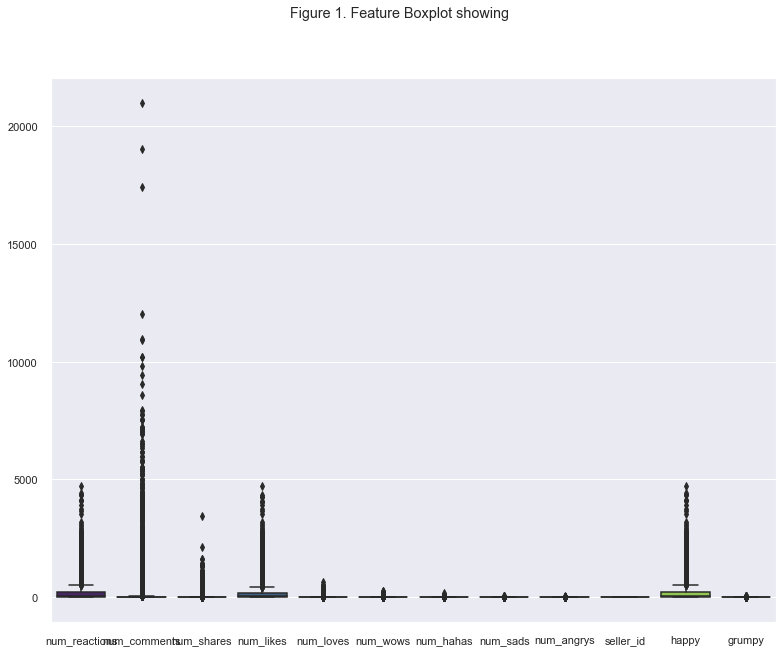

In [19]:
sb.set()
plt.figure(figsize=(13,10))
ax = sb.boxplot(data=data, orient='v', palette='viridis');
plt.suptitle('Figure 1. Feature Boxplot showing ')
plt.show()
plt.close('all')


>We identify 5 features containing most of the dataset outliers, let's check in depth each of these.

In [20]:
# Apply outliers() method on specific columns
l = ['num_reactions', 'num_comments', 'num_shares', 'num_likes',  'num_loves']
for i in l:
    outliers(data[i])


NUM_REACTIONS
Percentiles: 25th=17.000, 75th=219.000, IQR=202.000
Identified outliers: 705
Non-outlier observations: 6345
Outlier Percentage: 11.11 %

NUM_COMMENTS
Percentiles: 25th=0.000, 75th=23.000, IQR=23.000
Identified outliers: 1374
Non-outlier observations: 5676
Outlier Percentage: 24.21 %

NUM_SHARES
Percentiles: 25th=0.000, 75th=4.000, IQR=4.000
Identified outliers: 1393
Non-outlier observations: 5657
Outlier Percentage: 24.62 %

NUM_LIKES
Percentiles: 25th=17.000, 75th=184.750, IQR=167.750
Identified outliers: 774
Non-outlier observations: 6276
Outlier Percentage: 12.33 %

NUM_LOVES
Percentiles: 25th=0.000, 75th=3.000, IQR=3.000
Identified outliers: 1323
Non-outlier observations: 5727
Outlier Percentage: 23.10 %



### Feature Correlation

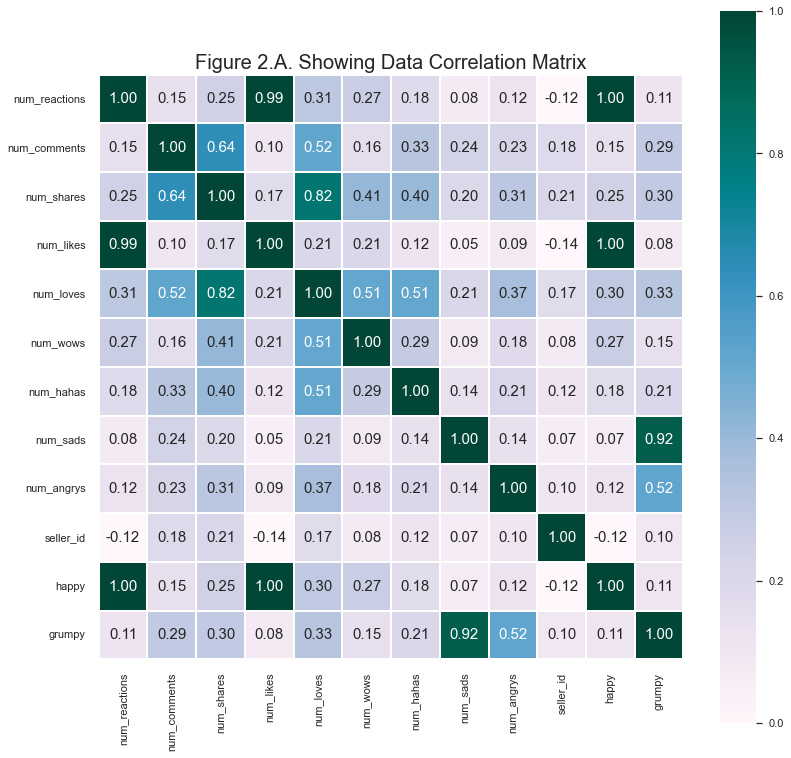

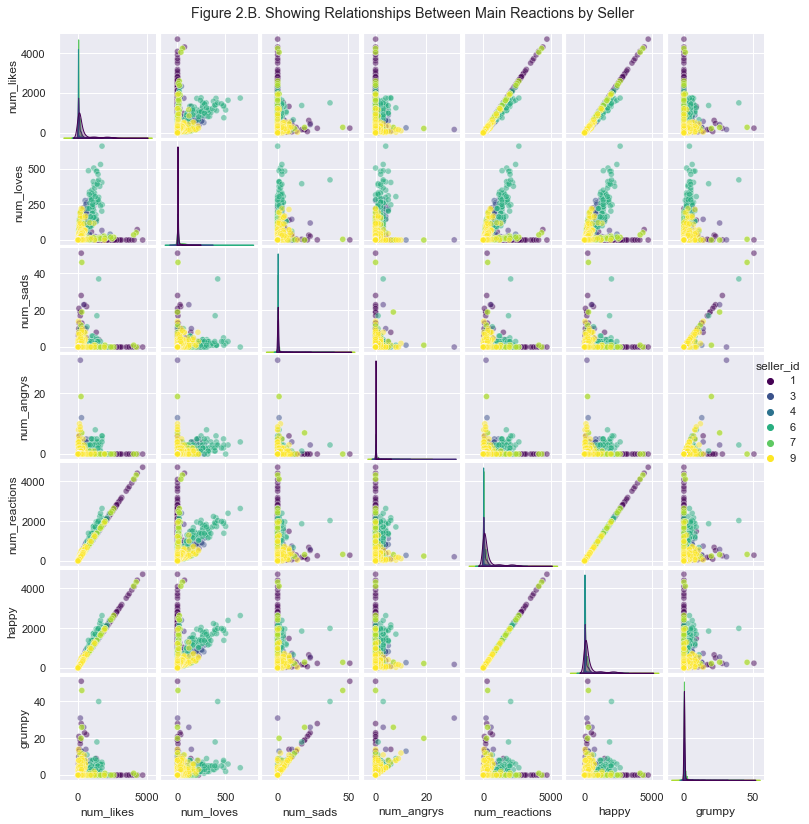

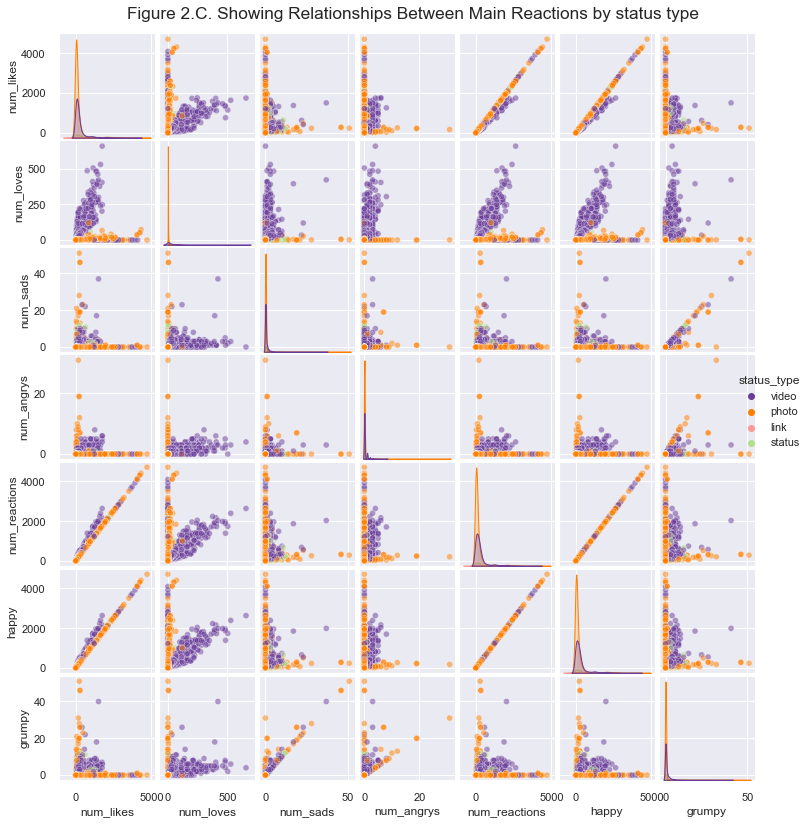

In [21]:
# get correlation matrix
data_corr = data.corr()

# set style and plot:

fig, ax = plt.subplots(figsize=(13.1,13.1))
ax = sb.heatmap(data = data_corr, 
               square = True,
               annot = True,
               cmap = 'PuBuGn',
               vmin = 0,
               vmax = 1,
               linewidths=2,
               ax=ax, 
               annot_kws={"size":15}, fmt='.2f')
            
plt.title('Figure 2.A. Showing Data Correlation Matrix', fontsize=20)

# pairplot with hue=seller_id(1-9)
ax = sb.pairplot(data=data,
                 vars = ['num_likes', 'num_loves','num_sads', 'num_angrys',
                        'num_reactions', 'happy', 'grumpy'],
                 hue='seller_id',
                 plot_kws={'alpha':0.5},
                 palette='viridis',
                 kind='scatter')
ax.fig.suptitle('Figure 2.B. Showing Relationships Between Main Reactions by Seller', y=1.02)
ax.fig.set_size_inches(11,11)

# pairplot with hue=status_type(video, photo, link, status)
ax = sb.pairplot(data=data,
                 vars = ['num_likes', 'num_loves','num_sads', 'num_angrys',
                        'num_reactions', 'happy', 'grumpy'],
                 hue='status_type',
                 plot_kws={'alpha':0.5},
                 palette='Paired_r',
                 kind='scatter')
sb.set(font_scale=1.2)
plt.suptitle('Figure 2.C. Showing Relationships Between Main Reactions by status type', y=1.02)
ax.fig.set_size_inches(11,11)

plt.show()
plt.close()

>Some sort of clustering already spotted.

> Automatically we spot an almost perfect linear correlation between:
> - Happy group that contains positive reactions
> - Number of reactions, wich contains all the reactions in the dataset(positives + negatives).
> - That correlation means negative reactions might be anecdotical so given the shapes above, a few match almost perfectly and an overwhelming proportion of positive reactions might overshadow the other groups, considering some dimensionality reduction though. Let's plot reactions Vs Likes

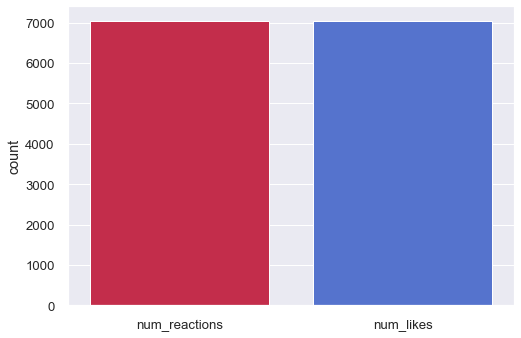

93.45 % of all the reactions are likes


In [22]:
ax = sb.countplot(data=data[['num_reactions', 'num_likes']], palette=['crimson', 'royalblue'])
plt.show()
plt.close()
print(round((data['num_likes'].sum()/data['num_reactions'].sum())*100, 2),'% of all the reactions are likes')

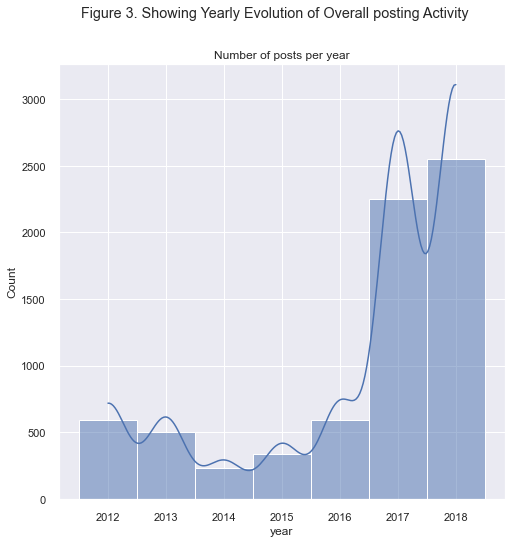

In [23]:
# Make Year column from datetime 
data['year_post'] = data['datetime'].map(lambda dt:dt.strftime('%Y'))

#Plot Sorted by Year 
sb.set()
plt.figure(figsize=(8,8))
ax = sb.histplot(data=data,
                 x=sorted(data['year_post']), 
                 bins=42,
                 kde=True)
plt.title('Number of posts per year')
plt.suptitle('Figure 3. Showing Yearly Evolution of Overall posting Activity')
plt.xlabel('year')

plt.show()
plt.close('all')

# Drop Year column once done
data = data.drop(['year_post'], axis=1)

In [24]:
data = data.drop(['happy','grumpy'], axis=1)

 
### Data Type Groups
 
 Divide features into numerical, categorical and time, since:
- Discrete features will have to be scaled in order to give equal importance to all features.
 
- Categorical features would have to be converted to binary using dummies, but since the K-means algorithm is based on minimizing euclidean distances (hence the continuous data) that doesn't work "well" with binary data (0's and 1's don't tell quite a difference, just one indeed) so we'll just group it.
 
- Datetime is already formatted to datetime object, but is either pointless or too demanding at this point of the exercise.

In [25]:
continuous_data = data[['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']]
categorical_data = data[['seller_id', 'status_type']]
time_data = data['datetime']

### Check for data distribution

Before any Standarization, let's see if individual features look like normally distributed data since model will behave badly on non gaussian data.

To do this we get a method that plots distribution for each feature.

Number of variables = 12
Desired Num of rows: 4
Desired Num of columns: 4


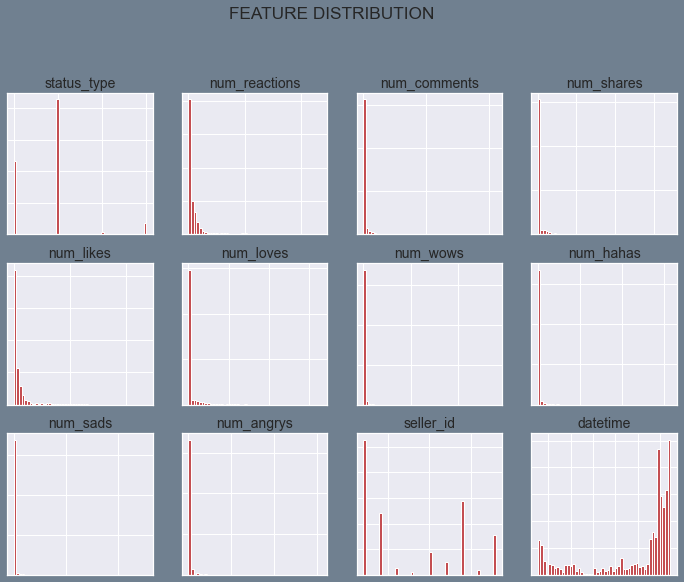

In [26]:
check_distribution(data)

### Scaling Discrete Numerical counts

We'll use robust scaler since we already saw the presence of many outliers across figures.

In [27]:
print('\nBefore:')
display(continuous_data)

robust_scaled = RobustScaler(quantile_range=(25, 75)).fit_transform(continuous_data)
robust_df = pd.DataFrame(data=robust_scaled, columns=continuous_data.columns)

print('\nAfter:')
display(robust_df)



Before:


,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,529,512,262,432,92,3,1,1,0
1,150,0,0,150,0,0,0,0,0
2,227,236,57,204,21,1,1,0,0
3,111,0,0,111,0,0,0,0,0
4,213,0,0,204,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...
7045,89,0,0,89,0,0,0,0,0
7046,16,0,0,14,1,0,1,0,0
7047,2,0,0,1,1,0,0,0,0
7048,351,12,22,349,2,0,0,0,0



After:


,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,2.324257,22.086957,65.50,2.229508,30.666667,3.0,1.0,1.0,0.0
1,0.448020,-0.173913,0.00,0.548435,0.000000,0.0,0.0,0.0,0.0
2,0.829208,10.086957,14.25,0.870343,7.000000,1.0,1.0,0.0,0.0
3,0.254950,-0.173913,0.00,0.315946,0.000000,0.0,0.0,0.0,0.0
4,0.759901,-0.173913,0.00,0.870343,3.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
7045,0.146040,-0.173913,0.00,0.184799,0.000000,0.0,0.0,0.0,0.0
7046,-0.215347,-0.173913,0.00,-0.262295,0.333333,0.0,1.0,0.0,0.0
7047,-0.284653,-0.173913,0.00,-0.339791,0.333333,0.0,0.0,0.0,0.0
7048,1.443069,0.347826,5.50,1.734724,0.666667,0.0,0.0,0.0,0.0



### PCA to speed up Machine Learning Algorithms

According to the linearity we found, there's much possibilities open to a feature reduction trough Principal Component Analysis.

To do so, we'll plot a graphic featuring explained variance across a number of components trough a specified range.

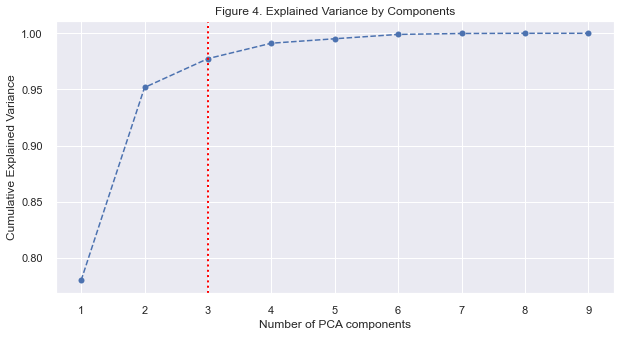

In [28]:
X = np.array(robust_df)
pca = PCA()
pca.fit(X)

plt.figure(figsize=(10,5))
ax = plt.plot(range(1,10), pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')

plt.title('Figure 4. Explained Variance by Components')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x = 3, ymin = 0, color = 'red', linewidth =2, ls = ':' )
plt.show()
plt.close()

>Given explained variance, we are seeing we could diferentiate +95% of the data with just 2-3 components, but since the reactions are overly imbalanced having 93% of likes amongst all reactions, we'll aim for 3 components trying to explain around 97% of the data. 

In [29]:
pca = PCA(n_components=3)
pca.fit(X)
scores_pca = pca.transform(X)
display(pd.DataFrame(scores_pca, columns=['Component_1','Component_2','Component_3']).describe())

,Component_1,Component_2,Component_3
count,7.050000e+03,7.050000e+03,7.050000e+03
mean,-1.094463e-14,7.174970e-15,1.653807e-15
std,4.725315e+01,2.218596e+01,8.578698e+00
min,-1.454277e+01,-5.579106e+02,-9.831468e+01
25%,-1.448047e+01,-2.112855e+00,-7.020545e-01
50%,-1.419283e+01,-2.042253e+00,-6.726170e-01
75%,-1.253157e+01,-1.524710e+00,7.243183e-02
max,7.119931e+02,5.763084e+02,1.977099e+02


# K-means Algorithm

Since we haven't specified the number of clusters, we will execute k-means on a range of clusters. Then we'll plot an elbow graphic, showing the sum of squared distances within the cluster (the lesser the best) and the range of specified clusters.

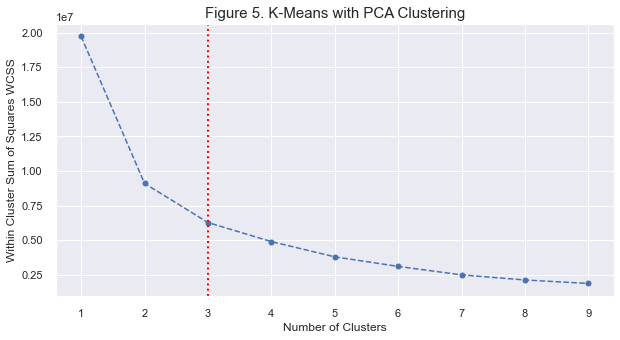

In [30]:
wcss = []
for i in range(1,10):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=12)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares WCSS')
plt.title('Figure 5. K-Means with PCA Clustering', fontsize=15)
plt.axvline(x = 3, ymin = 0, color = 'red', linewidth =2, ls = ':' )
plt.show()
plt.close()

>Two and Three clusters seem to be where the sweet spot is.

### Visualization of the PCA components

>We'll get the centroids of the three requested clusters, being able to show a 3-Dimensional plot with the clustering of the 3 components obtained from PCA (see fig.6.A)

>We can plot 2D as well showing all the relations between the clustering of pairs PCA components, much like changing the camera perspective across the three axes to get detail of the data dimensionality (see fig.6.B/C/D) 


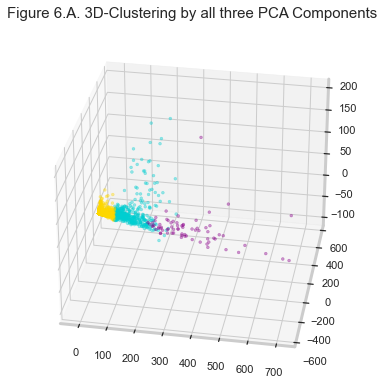

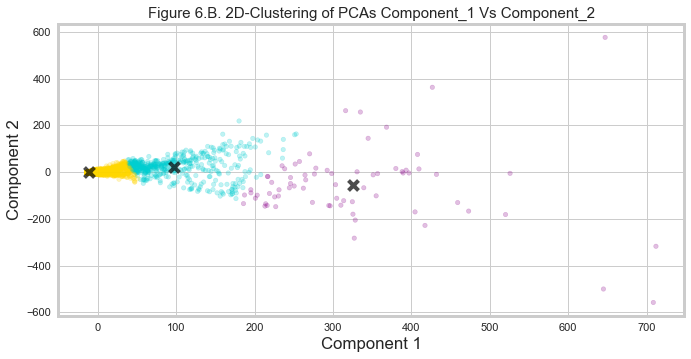

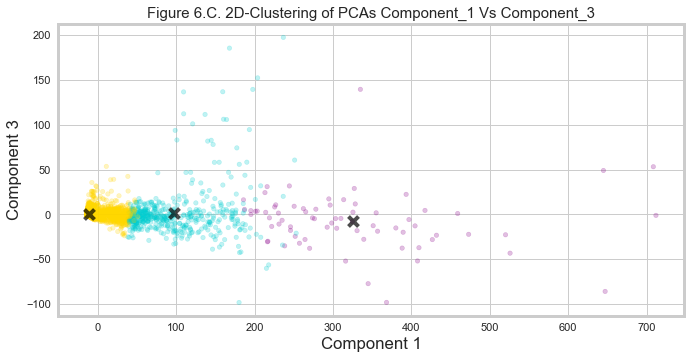

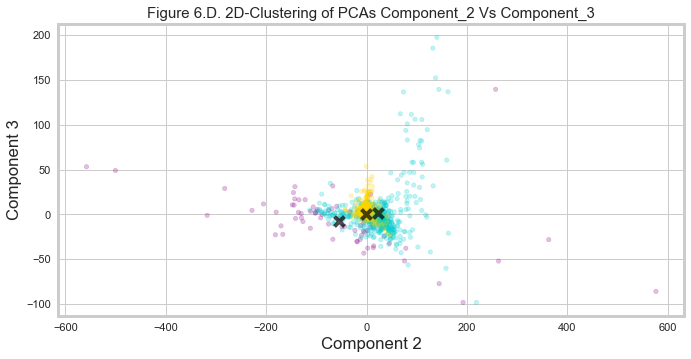

In [42]:
sb.set_style()
kmeans = KMeans(n_clusters=3).fit(scores_pca)

# Predicting the clusters
labels = kmeans.predict(scores_pca)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['gold','darkturquoise','darkmagenta']
asignar=[]
for row in labels:
    asignar.append(colores[row])

# Plot in 3D since we reduced to three dimensions
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig, azim=-80, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(scores_pca[:, 0], scores_pca[:, 1], scores_pca[:, 2], c=asignar,s=8, alpha=0.4)
plt.title('Figure 6.A. 3D-Clustering by all three PCA Components', fontsize=15)

f1 = pd.DataFrame(scores_pca[:, 0]).values
f2 = pd.DataFrame(scores_pca[:, 1]).values
f3 = pd.DataFrame(scores_pca[:, 2]).values

# plot each of the 3 PCA components Vs the other
# plot 1 vs 2
sb.set_style('whitegrid')
fig = plt.figure(figsize=(10,5))
ax = plt.scatter(f1, f2, c=asignar, s=20, alpha=0.25)
plt.scatter(C[:, 0], C[:, 1], marker='x', c='black', s=100, alpha=0.7)
plt.title('Figure 6.B. 2D-Clustering of PCAs Component_1 Vs Component_2', fontsize=15)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# plot 1 vs 3
fig = plt.figure(figsize=(10,5))
ax1 = plt.scatter(f1, f3, c=asignar, s=20, alpha=0.25)
plt.scatter(C[:, 0], C[:, 2], marker='x', c='black', s=100, alpha=0.7)
plt.title('Figure 6.C. 2D-Clustering of PCAs Component_1 Vs Component_3', fontsize=15)
plt.xlabel('Component 1')
plt.ylabel('Component 3')

# plot 2 vs 3
fig = plt.figure(figsize=(10,5))
ax2 = plt.scatter(f2, f3, c=asignar, s=20, alpha=0.25)
plt.scatter(C[:, 1], C[:, 2], marker='x', c='black', s=100, alpha=0.7)
plt.title('Figure 6.D. 2D-Clustering of PCAs Component_2 Vs Component_3', fontsize=15)
plt.xlabel('Component 2')
plt.ylabel('Component 3')

plt.show()
plt.close('all')


___

# Exercici 2

Classifica els diferents registres utilitzant l'algorisme de clustering jeràrquic.

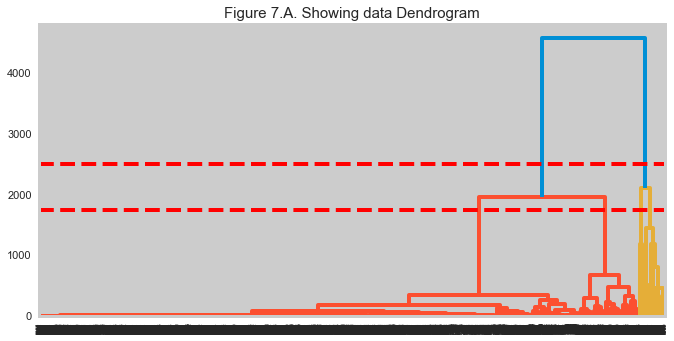

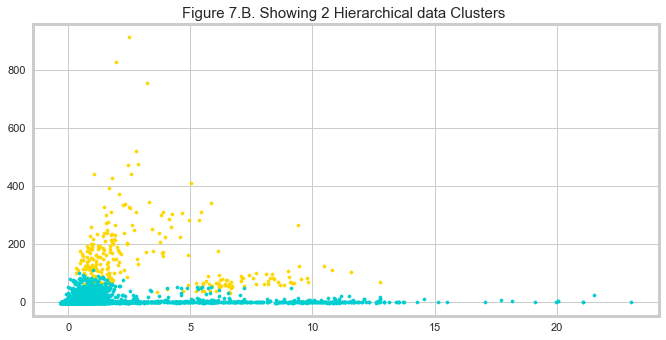

In [36]:
sb.set_style('whitegrid')
plt.figure(figsize=(10,5))
ax = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=2500, color='red', linestyle='--')
plt.axhline(y=1750, color='red', linestyle='--')
plt.title('Figure 7.A. Showing data Dendrogram', fontsize=15)

plt.show()
plt.close()

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_  
plt.figure(figsize=(10,5))
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=10, marker='o', color='gold')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=10, marker='o', color='darkturquoise')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=10, marker='o', color='darkmagenta')
plt.scatter(X[labels==3, 0], X[labels==3, 1], s=10, marker='o', color='r')
plt.title('Figure 7.B. Showing 2 Hierarchical data Clusters ', fontsize=15)

plt.show()
plt.close()

# Exercici 3

Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

>Let's take silhouette score as a metric to see the best choice for k

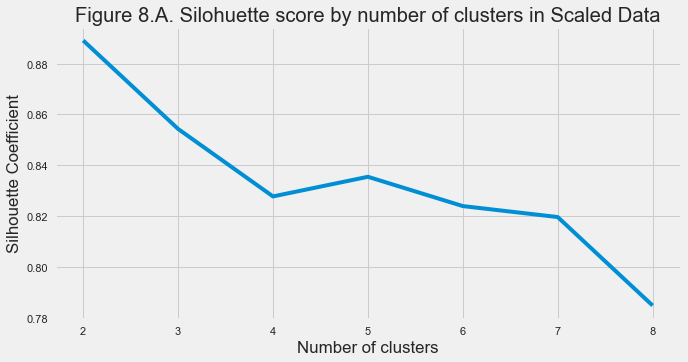

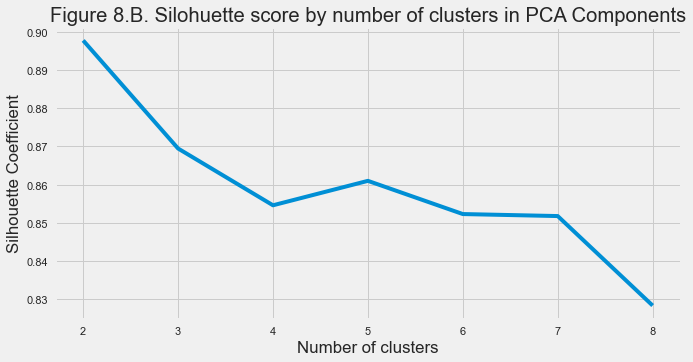

In [33]:
silhouette_coefficients = []
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}

for k in range(2,9):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,5))
plt.plot(range(2,9), silhouette_coefficients)
plt.xticks(range(2,9))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Figure 8.A. Silohuette score by number of clusters in Scaled Data')
plt.show()
plt.close()


silhouette_coefficients = []
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}

for k in range(2,9):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scores_pca)
    score = silhouette_score(scores_pca, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,5))
plt.plot(range(2,9), silhouette_coefficients)
plt.xticks(range(2,9))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Figure 8.B. Silohuette score by number of clusters in PCA Components')
plt.show()
plt.close()



>We see that Silhouette Score improved around 2 cents with the use of PCA components. Since both graphics show that clusterization decrease from 2 clusters onwards, we should decide to use just 2 PCA components seen that 3 component doesn't add much information.


### References

- \[1\] UCI Machine Learning Repository Website, [Original Dataset Link](https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand)  


- \[2\] Nassim Dehouche , Dataset on usage and engagement patterns for Face-book Live sellers in Thailand, Data in Brief (2020), doi: https://doi.org/10.1016/j.dib.2020.105661)  


- \[3\] Ola Kozielska, How Does the Facebook Algorithm Work: Everything You Need to Know in 2022 (+22 Tips), [How Facebook algorithm works in 2022](https://www.kontentino.com/blog/how-does-facebook-algorithm-work/)